# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4669440/11490434 [===========>..................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 10:27 - loss: 0.6960

  37/1875 [..............................] - ETA: 2s - loss: 0.5244   

  79/1875 [>.............................] - ETA: 2s - loss: 0.4381

 118/1875 [>.............................] - ETA: 2s - loss: 0.3990

 145/1875 [=>............................] - ETA: 2s - loss: 0.3805

 178/1875 [=>............................] - ETA: 2s - loss: 0.3631

 213/1875 [==>...........................] - ETA: 2s - loss: 0.3484

 245/1875 [==>...........................] - ETA: 2s - loss: 0.3373

 277/1875 [===>..........................] - ETA: 2s - loss: 0.3278

 308/1875 [===>..........................] - ETA: 2s - loss: 0.3197

 340/1875 [====>.........................] - ETA: 2s - loss: 0.3122

 372/1875 [====>.........................] - ETA: 2s - loss: 0.3055

 403/1875 [=====>........................] - ETA: 2s - loss: 0.2997

 437/1875 [=====>........................] - ETA: 2s - loss: 0.2938

 472/1875 [======>.......................] - ETA: 2s - loss: 0.2883

 501/1875 [=======>......................] - ETA: 2s - loss: 0.2841

 532/1875 [=======>......................] - ETA: 2s - loss: 0.2799

 565/1875 [========>.....................] - ETA: 2s - loss: 0.2757

 597/1875 [========>.....................] - ETA: 1s - loss: 0.2719

 632/1875 [=========>....................] - ETA: 1s - loss: 0.2681

 672/1875 [=========>....................] - ETA: 1s - loss: 0.2640

 707/1875 [==========>...................] - ETA: 1s - loss: 0.2606

 744/1875 [==========>...................] - ETA: 1s - loss: 0.2573

 777/1875 [===========>..................] - ETA: 1s - loss: 0.2545

 811/1875 [===========>..................] - ETA: 1s - loss: 0.2517

 847/1875 [============>.................] - ETA: 1s - loss: 0.2489

 886/1875 [=============>................] - ETA: 1s - loss: 0.2461

 927/1875 [=============>................] - ETA: 1s - loss: 0.2432

 968/1875 [==============>...............] - ETA: 1s - loss: 0.2405

1006/1875 [===============>..............] - ETA: 1s - loss: 0.2381

1039/1875 [===============>..............] - ETA: 1s - loss: 0.2362

1073/1875 [================>.............] - ETA: 1s - loss: 0.2342

1101/1875 [================>.............] - ETA: 1s - loss: 0.2326

1133/1875 [=================>............] - ETA: 1s - loss: 0.2309

1161/1875 [=================>............] - ETA: 1s - loss: 0.2295

1189/1875 [==================>...........] - ETA: 1s - loss: 0.2280

1217/1875 [==================>...........] - ETA: 0s - loss: 0.2267

1240/1875 [==================>...........] - ETA: 0s - loss: 0.2256

1269/1875 [===================>..........] - ETA: 0s - loss: 0.2242

1300/1875 [===================>..........] - ETA: 0s - loss: 0.2228

1328/1875 [====================>.........] - ETA: 0s - loss: 0.2216

1353/1875 [====================>.........] - ETA: 0s - loss: 0.2205

1385/1875 [=====================>........] - ETA: 0s - loss: 0.2191

1418/1875 [=====================>........] - ETA: 0s - loss: 0.2178

1449/1875 [======================>.......] - ETA: 0s - loss: 0.2166

1476/1875 [======================>.......] - ETA: 0s - loss: 0.2155

1507/1875 [=======================>......] - ETA: 0s - loss: 0.2144

1529/1875 [=======================>......] - ETA: 0s - loss: 0.2136

1561/1875 [=======================>......] - ETA: 0s - loss: 0.2124

1590/1875 [========================>.....] - ETA: 0s - loss: 0.2114

1623/1875 [========================>.....] - ETA: 0s - loss: 0.2102

1653/1875 [=========================>....] - ETA: 0s - loss: 0.2092

1685/1875 [=========================>....] - ETA: 0s - loss: 0.2082

1707/1875 [==========================>...] - ETA: 0s - loss: 0.2075

1733/1875 [==========================>...] - ETA: 0s - loss: 0.2067

1763/1875 [===========================>..] - ETA: 0s - loss: 0.2057

1796/1875 [===========================>..] - ETA: 0s - loss: 0.2048

1820/1875 [============================>.] - ETA: 0s - loss: 0.2040

1848/1875 [============================>.] - ETA: 0s - loss: 0.2032

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2024


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1136

  34/1875 [..............................] - ETA: 2s - loss: 0.1125

  72/1875 [>.............................] - ETA: 2s - loss: 0.1119

 100/1875 [>.............................] - ETA: 2s - loss: 0.1116

 127/1875 [=>............................] - ETA: 2s - loss: 0.1114

 155/1875 [=>............................] - ETA: 2s - loss: 0.1112

 186/1875 [=>............................] - ETA: 2s - loss: 0.1110

 215/1875 [==>...........................] - ETA: 2s - loss: 0.1109

 244/1875 [==>...........................] - ETA: 2s - loss: 0.1107

 275/1875 [===>..........................] - ETA: 2s - loss: 0.1105

 306/1875 [===>..........................] - ETA: 2s - loss: 0.1104

 332/1875 [====>.........................] - ETA: 2s - loss: 0.1103

 358/1875 [====>.........................] - ETA: 2s - loss: 0.1102

 391/1875 [=====>........................] - ETA: 2s - loss: 0.1100

 425/1875 [=====>........................] - ETA: 2s - loss: 0.1099

 455/1875 [======>.......................] - ETA: 2s - loss: 0.1098

 484/1875 [======>.......................] - ETA: 2s - loss: 0.1097

 520/1875 [=======>......................] - ETA: 2s - loss: 0.1096

 555/1875 [=======>......................] - ETA: 2s - loss: 0.1095

 592/1875 [========>.....................] - ETA: 2s - loss: 0.1093

 625/1875 [=========>....................] - ETA: 2s - loss: 0.1092

 658/1875 [=========>....................] - ETA: 2s - loss: 0.1091

 688/1875 [==========>...................] - ETA: 1s - loss: 0.1091

 723/1875 [==========>...................] - ETA: 1s - loss: 0.1090

 750/1875 [===========>..................] - ETA: 1s - loss: 0.1089

 784/1875 [===========>..................] - ETA: 1s - loss: 0.1088

 814/1875 [============>.................] - ETA: 1s - loss: 0.1087

 840/1875 [============>.................] - ETA: 1s - loss: 0.1086

 872/1875 [============>.................] - ETA: 1s - loss: 0.1086

 904/1875 [=============>................] - ETA: 1s - loss: 0.1085

 934/1875 [=============>................] - ETA: 1s - loss: 0.1084

 968/1875 [==============>...............] - ETA: 1s - loss: 0.1083

 995/1875 [==============>...............] - ETA: 1s - loss: 0.1083

1030/1875 [===============>..............] - ETA: 1s - loss: 0.1082

1055/1875 [===============>..............] - ETA: 1s - loss: 0.1081

1090/1875 [================>.............] - ETA: 1s - loss: 0.1081

1123/1875 [================>.............] - ETA: 1s - loss: 0.1080

1155/1875 [=================>............] - ETA: 1s - loss: 0.1079

1186/1875 [=================>............] - ETA: 1s - loss: 0.1079

1221/1875 [==================>...........] - ETA: 1s - loss: 0.1078

1254/1875 [===================>..........] - ETA: 1s - loss: 0.1077

1287/1875 [===================>..........] - ETA: 0s - loss: 0.1077

1319/1875 [====================>.........] - ETA: 0s - loss: 0.1076

1352/1875 [====================>.........] - ETA: 0s - loss: 0.1075

1384/1875 [=====================>........] - ETA: 0s - loss: 0.1075

1419/1875 [=====================>........] - ETA: 0s - loss: 0.1074

1452/1875 [======================>.......] - ETA: 0s - loss: 0.1073

1485/1875 [======================>.......] - ETA: 0s - loss: 0.1073

1514/1875 [=======================>......] - ETA: 0s - loss: 0.1072

1545/1875 [=======================>......] - ETA: 0s - loss: 0.1072

1576/1875 [========================>.....] - ETA: 0s - loss: 0.1071

1607/1875 [========================>.....] - ETA: 0s - loss: 0.1070

1639/1875 [=========================>....] - ETA: 0s - loss: 0.1070

1673/1875 [=========================>....] - ETA: 0s - loss: 0.1069

1707/1875 [==========================>...] - ETA: 0s - loss: 0.1069

1740/1875 [==========================>...] - ETA: 0s - loss: 0.1068

1774/1875 [===========================>..] - ETA: 0s - loss: 0.1067

1807/1875 [===========================>..] - ETA: 0s - loss: 0.1067

1842/1875 [============================>.] - ETA: 0s - loss: 0.1066

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1066


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1091

  34/1875 [..............................] - ETA: 2s - loss: 0.0985

  64/1875 [>.............................] - ETA: 2s - loss: 0.0985

  94/1875 [>.............................] - ETA: 2s - loss: 0.0985

 126/1875 [=>............................] - ETA: 2s - loss: 0.0985

 158/1875 [=>............................] - ETA: 2s - loss: 0.0986

 190/1875 [==>...........................] - ETA: 2s - loss: 0.0986

 220/1875 [==>...........................] - ETA: 2s - loss: 0.0986

 248/1875 [==>...........................] - ETA: 2s - loss: 0.0986

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0986

 306/1875 [===>..........................] - ETA: 2s - loss: 0.0986

 335/1875 [====>.........................] - ETA: 2s - loss: 0.0986

 367/1875 [====>.........................] - ETA: 2s - loss: 0.0986

 400/1875 [=====>........................] - ETA: 2s - loss: 0.0986

 428/1875 [=====>........................] - ETA: 2s - loss: 0.0986

 455/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 485/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 513/1875 [=======>......................] - ETA: 2s - loss: 0.0985

 542/1875 [=======>......................] - ETA: 2s - loss: 0.0985

 574/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 598/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 627/1875 [=========>....................] - ETA: 2s - loss: 0.0985

 657/1875 [=========>....................] - ETA: 2s - loss: 0.0985

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0985

 714/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 742/1875 [==========>...................] - ETA: 1s - loss: 0.0985

 769/1875 [===========>..................] - ETA: 1s - loss: 0.0984

 802/1875 [===========>..................] - ETA: 1s - loss: 0.0984

 834/1875 [============>.................] - ETA: 1s - loss: 0.0984

 865/1875 [============>.................] - ETA: 1s - loss: 0.0984

 896/1875 [=============>................] - ETA: 1s - loss: 0.0984

 929/1875 [=============>................] - ETA: 1s - loss: 0.0984

 960/1875 [==============>...............] - ETA: 1s - loss: 0.0984

 991/1875 [==============>...............] - ETA: 1s - loss: 0.0984

1022/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1053/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1085/1875 [================>.............] - ETA: 1s - loss: 0.0983

1115/1875 [================>.............] - ETA: 1s - loss: 0.0983

1146/1875 [=================>............] - ETA: 1s - loss: 0.0983

1179/1875 [=================>............] - ETA: 1s - loss: 0.0983

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0983

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0983

1278/1875 [===================>..........] - ETA: 0s - loss: 0.0983

1305/1875 [===================>..........] - ETA: 0s - loss: 0.0983

1334/1875 [====================>.........] - ETA: 0s - loss: 0.0983

1368/1875 [====================>.........] - ETA: 0s - loss: 0.0982

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0982

1428/1875 [=====================>........] - ETA: 0s - loss: 0.0982

1461/1875 [======================>.......] - ETA: 0s - loss: 0.0982

1489/1875 [======================>.......] - ETA: 0s - loss: 0.0982

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0982

1548/1875 [=======================>......] - ETA: 0s - loss: 0.0982

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0982

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0982

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0981

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0981

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0981

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0981

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0981

1822/1875 [============================>.] - ETA: 0s - loss: 0.0981

1849/1875 [============================>.] - ETA: 0s - loss: 0.0981

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0981


Epoch 4/5


   1/1875 [..............................] - ETA: 4s - loss: 0.0955

  29/1875 [..............................] - ETA: 3s - loss: 0.0961

  56/1875 [..............................] - ETA: 3s - loss: 0.0960

  82/1875 [>.............................] - ETA: 3s - loss: 0.0961

 111/1875 [>.............................] - ETA: 3s - loss: 0.0962

 129/1875 [=>............................] - ETA: 3s - loss: 0.0962

 156/1875 [=>............................] - ETA: 3s - loss: 0.0962

 183/1875 [=>............................] - ETA: 3s - loss: 0.0962

 216/1875 [==>...........................] - ETA: 3s - loss: 0.0962

 247/1875 [==>...........................] - ETA: 3s - loss: 0.0963

 279/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 310/1875 [===>..........................] - ETA: 2s - loss: 0.0963

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 374/1875 [====>.........................] - ETA: 2s - loss: 0.0963

 406/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 438/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 471/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 497/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 529/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 558/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 586/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 615/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 648/1875 [=========>....................] - ETA: 2s - loss: 0.0962

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0962

 706/1875 [==========>...................] - ETA: 2s - loss: 0.0962

 735/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 766/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 798/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 831/1875 [============>.................] - ETA: 1s - loss: 0.0962

 863/1875 [============>.................] - ETA: 1s - loss: 0.0962

 894/1875 [=============>................] - ETA: 1s - loss: 0.0962

 923/1875 [=============>................] - ETA: 1s - loss: 0.0962

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0962

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0962

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1082/1875 [================>.............] - ETA: 1s - loss: 0.0962

1109/1875 [================>.............] - ETA: 1s - loss: 0.0962

1143/1875 [=================>............] - ETA: 1s - loss: 0.0962

1176/1875 [=================>............] - ETA: 1s - loss: 0.0962

1210/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1276/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1309/1875 [===================>..........] - ETA: 0s - loss: 0.0961

1340/1875 [====================>.........] - ETA: 0s - loss: 0.0961

1372/1875 [====================>.........] - ETA: 0s - loss: 0.0961

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1441/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1493/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1594/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1826/1875 [============================>.] - ETA: 0s - loss: 0.0961

1854/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0870

  28/1875 [..............................] - ETA: 3s - loss: 0.0931

  55/1875 [..............................] - ETA: 3s - loss: 0.0940

  79/1875 [>.............................] - ETA: 3s - loss: 0.0944

 104/1875 [>.............................] - ETA: 3s - loss: 0.0947

 133/1875 [=>............................] - ETA: 3s - loss: 0.0949

 162/1875 [=>............................] - ETA: 3s - loss: 0.0950

 187/1875 [=>............................] - ETA: 3s - loss: 0.0951

 217/1875 [==>...........................] - ETA: 3s - loss: 0.0951

 248/1875 [==>...........................] - ETA: 3s - loss: 0.0951

 282/1875 [===>..........................] - ETA: 2s - loss: 0.0952

 307/1875 [===>..........................] - ETA: 2s - loss: 0.0952

 333/1875 [====>.........................] - ETA: 2s - loss: 0.0952

 363/1875 [====>.........................] - ETA: 2s - loss: 0.0952

 391/1875 [=====>........................] - ETA: 2s - loss: 0.0952

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 453/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 485/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 513/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 600/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 630/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 659/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 712/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 741/1875 [==========>...................] - ETA: 2s - loss: 0.0953

 765/1875 [===========>..................] - ETA: 2s - loss: 0.0953

 792/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 824/1875 [============>.................] - ETA: 1s - loss: 0.0953

 850/1875 [============>.................] - ETA: 1s - loss: 0.0953

 881/1875 [=============>................] - ETA: 1s - loss: 0.0953

 912/1875 [=============>................] - ETA: 1s - loss: 0.0953

 940/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 998/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1080/1875 [================>.............] - ETA: 1s - loss: 0.0953

1112/1875 [================>.............] - ETA: 1s - loss: 0.0953

1148/1875 [=================>............] - ETA: 1s - loss: 0.0953

1185/1875 [=================>............] - ETA: 1s - loss: 0.0953

1220/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1254/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1288/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1322/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1356/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1390/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1499/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1559/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1588/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1619/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1672/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1831/1875 [============================>.] - ETA: 0s - loss: 0.0953

1864/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

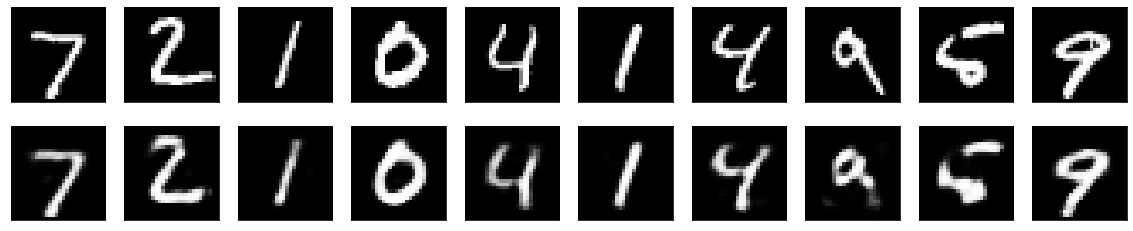

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
